# Kannada Digit Recogniser

Re-Running my notebook for [Digit recogniser](https://www.kaggle.com/cristianfat/digit-recogniser)

## Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
import os

## Data

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/Kannada-MNIST/Dig-MNIST.csv
/kaggle/input/Kannada-MNIST/train.csv
/kaggle/input/Kannada-MNIST/test.csv
/kaggle/input/Kannada-MNIST/sample_submission.csv


**Load data**

In [4]:
train = pd.read_csv('/kaggle/input/Kannada-MNIST/train.csv')
test = pd.read_csv('/kaggle/input/Kannada-MNIST/test.csv')

**Number of train samples by label**

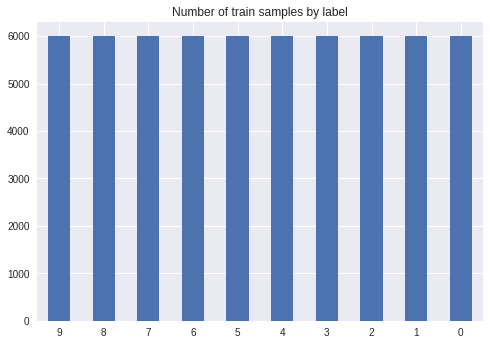

In [5]:
train.label.value_counts().plot.bar(rot=0,title='Number of train samples by label');

**Random Sample to Image**

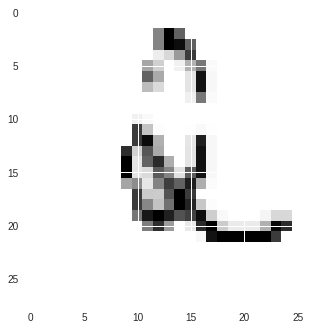

In [10]:
plt.imshow(train[train.columns[1:]].sample(1).values.ravel().reshape(28,28));

**Train / Test data**

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
train_, test_ = train_test_split(train,test_size=0.33,random_state=42,stratify=train.label)

**Check if the data it's fair splitted based on label**

In [13]:
'train',train_.label.value_counts() / len(train_),'test',test_.label.value_counts() / len(test_)

('train',
 9    0.1
 8    0.1
 7    0.1
 6    0.1
 5    0.1
 4    0.1
 3    0.1
 2    0.1
 1    0.1
 0    0.1
 Name: label, dtype: float64,
 'test',
 9    0.1
 8    0.1
 7    0.1
 6    0.1
 5    0.1
 4    0.1
 3    0.1
 2    0.1
 1    0.1
 0    0.1
 Name: label, dtype: float64)

**KNN**

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [16]:
%%time
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_[train_.columns[1:]],train_['label'])

CPU times: user 9.29 s, sys: 261 ms, total: 9.55 s
Wall time: 9.51 s


KNeighborsClassifier(n_neighbors=3)

In [17]:
%%time
knn_results = test_.copy()
knn_results['y_pred'] = knn.predict(test_[test_.columns[1:]])

CPU times: user 25min 59s, sys: 301 ms, total: 26min
Wall time: 26min


In [18]:
print(metrics.classification_report(knn_results.label,knn_results.y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1980
           1       0.96      1.00      0.98      1980
           2       1.00      1.00      1.00      1980
           3       0.99      0.98      0.98      1980
           4       0.98      1.00      0.99      1980
           5       1.00      0.98      0.99      1980
           6       0.96      0.98      0.97      1980
           7       0.97      0.97      0.97      1980
           8       1.00      0.98      0.99      1980
           9       1.00      0.98      0.99      1980

    accuracy                           0.98     19800
   macro avg       0.98      0.98      0.98     19800
weighted avg       0.98      0.98      0.98     19800



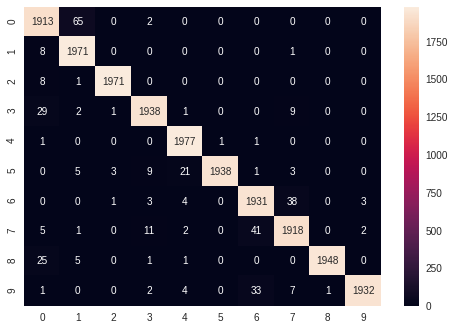

In [19]:
sns.heatmap(metrics.confusion_matrix(knn_results.label,knn_results.y_pred),annot=True,fmt='d');

**XGBoost**

In [20]:
import xgboost as xgb

In [21]:
%%time
xgc = xgb.XGBClassifier(objective='multi:softmax',num_class=train.label.nunique(),n_estimators=300)
xgc.fit(train_[train_.columns[1:]],train_['label'],verbose=1000)

CPU times: user 1h 37min 38s, sys: 8.44 s, total: 1h 37min 47s
Wall time: 25min 17s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=0, num_class=10, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [22]:
%%time
xgc_results = test_.copy()
xgc_results['y_pred'] = xgc.predict(test_[test_.columns[1:]])

CPU times: user 7.73 s, sys: 434 ms, total: 8.16 s
Wall time: 2.71 s


In [23]:
print(metrics.classification_report(xgc_results.label,xgc_results.y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1980
           1       0.98      0.99      0.99      1980
           2       1.00      1.00      1.00      1980
           3       0.99      0.98      0.98      1980
           4       0.98      0.99      0.99      1980
           5       0.99      0.99      0.99      1980
           6       0.97      0.99      0.98      1980
           7       0.98      0.98      0.98      1980
           8       1.00      0.99      0.99      1980
           9       0.99      0.98      0.99      1980

    accuracy                           0.99     19800
   macro avg       0.99      0.99      0.99     19800
weighted avg       0.99      0.99      0.99     19800



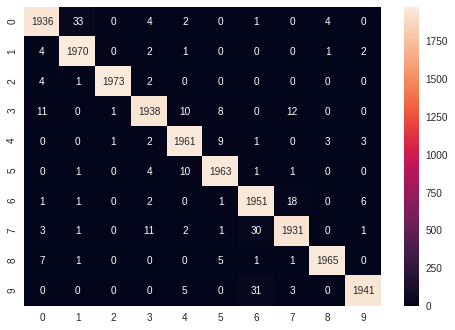

In [24]:
sns.heatmap(metrics.confusion_matrix(xgc_results.label,xgc_results.y_pred),annot=True,fmt='d');

**Train on Full Data then create submission file**

In [26]:
dig = pd.read_csv('/kaggle/input/Kannada-MNIST/Dig-MNIST.csv')
train_plus_dig = pd.concat([train,dig],ignore_index=True)

In [27]:
%%time
full_xgc = xgb.XGBClassifier(objective='multi:softmax',num_class=train_plus_dig.label.nunique(),n_estimators=300)
full_xgc.fit(train_plus_dig[train_plus_dig.columns[1:]],train_plus_dig['label'],verbose=1000)

CPU times: user 3h 20min 56s, sys: 16.3 s, total: 3h 21min 13s
Wall time: 51min 57s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=0, num_class=10, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [30]:
train_plus_dig

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70235,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
70236,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
70237,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
70238,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
%%time
full_xgc_results = test.copy()
full_xgc_results['y_pred'] = full_xgc.predict(test[test.columns[1:]])

CPU times: user 2.26 s, sys: 57.8 ms, total: 2.32 s
Wall time: 759 ms


In [34]:
full_xgc_results['id'] = list(range(0,len(test)))
full_xgc_results[['id','y_pred']].rename(columns={'y_pred':'label'}).to_csv('submission.csv',index=False)